In [15]:
pip install yfinance

In [16]:
# IMPORTS
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sbn
import datetime as dt
import scipy.stats as stats
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

In [17]:
# LOAD DATA
start = dt.datetime(2022,4,1)
end = dt.datetime(2022,5,1)
# COIN 0 IS TRADED AT UNIT PER POSITION
# COIN 1 IS TRADED AT RATIO UNITS PER POSITION
COINS = ['BTC-USD', 'ETH-USD']
# this horrible function (below) sorts the coins into alphabetical order and 
# idk how to prevent this, coin 0 must always be alphabetically before coin 1
prices = yf.download(COINS, start, interval = "30m")
returns = np.log(1+ prices['Adj Close'].pct_change()).dropna()
prices, returns = prices['Adj Close'].to_numpy(), returns.to_numpy()
print(prices.shape)
print(prices)


[*********************100%***********************]  2 of 2 completed
(1807, 2)
[[45670.49609375  3295.33374023]
 [45597.73046875  3300.4597168 ]
 [45344.94921875  3286.78051758]
 ...
 [34470.265625    2526.3203125 ]
 [34466.62109375  2525.7421875 ]
 [34510.83203125  2531.8112793 ]]


In [18]:
price_ratio = np.divide(prices[:,0],prices[:,1])
print(price_ratio.shape)
M = 200 # Discrete time M-fold averager:
avg_price_ratio = np.convolve(price_ratio, np.ones(M), 'valid') / M
#print(avg_price_ratio)

(1807,)


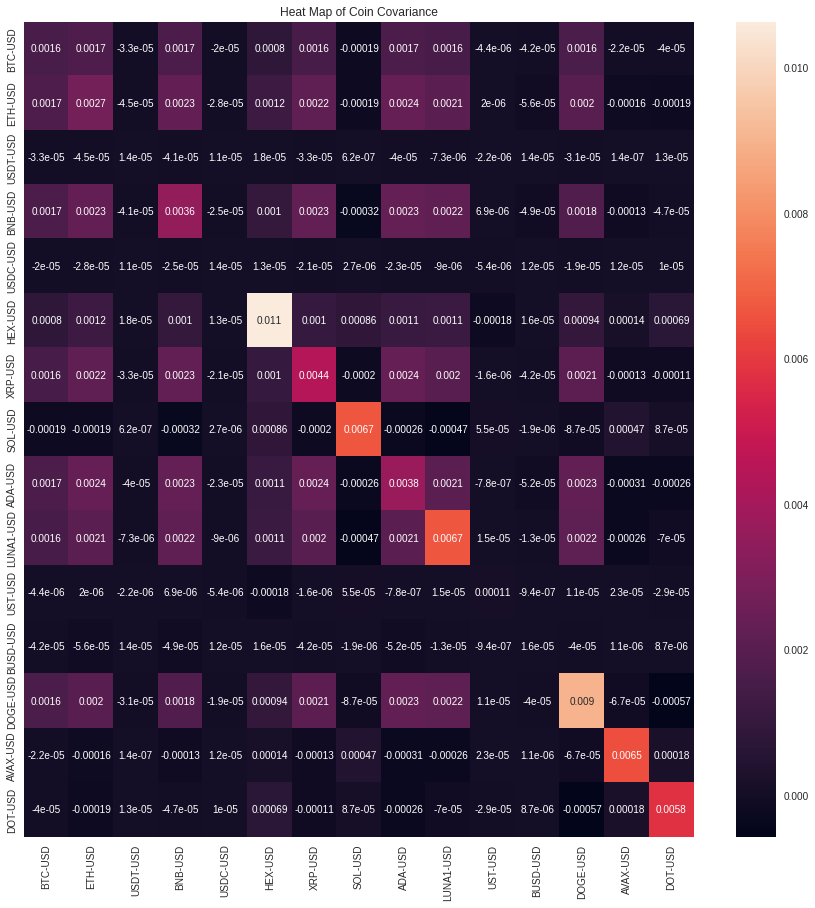

<Figure size 9600x6600 with 0 Axes>

['BTC-USD', 'ETH-USD']


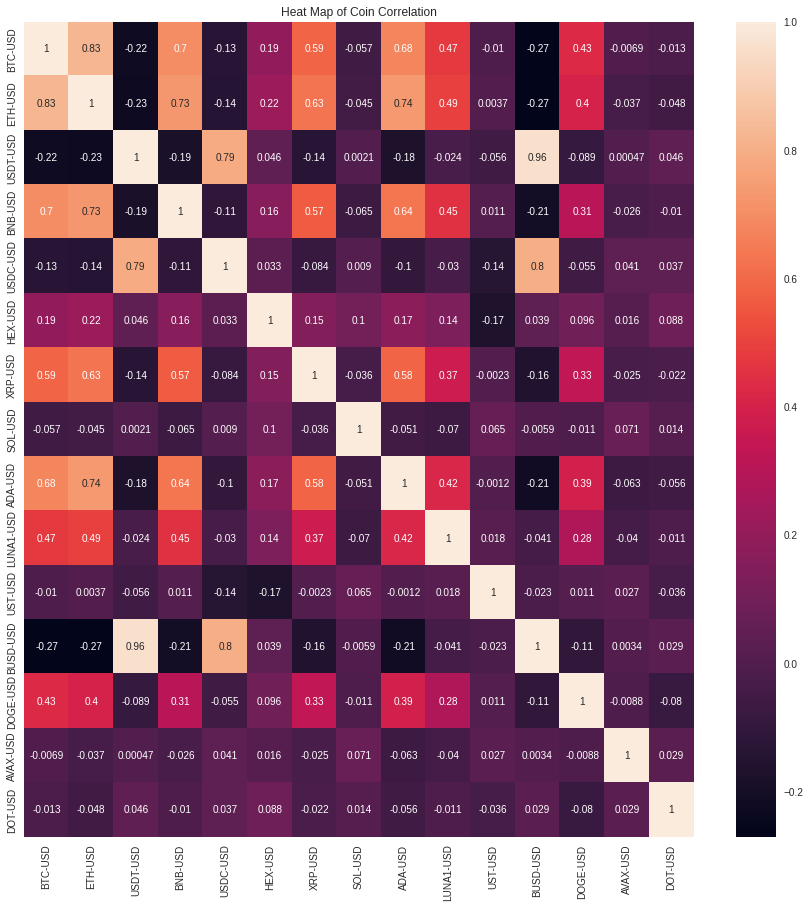

In [19]:
TOP10 = ['BTC-USD', 'ETH-USD','USDT-USD', 'BNB-USD','USDC-USD', 'HEX-USD', 'XRP-USD','SOL-USD','ADA-USD','LUNA1-USD','UST-USD', 'BUSD-USD','DOGE-USD','AVAX-USD','DOT-USD']

# Takes in cov matrix and returns correlation coeff matrix wz vals e (0, 1)
def correlation_coeffs(cov):
    l = len(cov)
    coeffs = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            coeffs[i, j] = cov[i, j] / (math.sqrt(cov[i, i]) * math.sqrt(cov[j, j]))
    return coeffs
    
def covariance(coins, start, end):
    # input: coins array, start date, end date
    # output: covariance matrix
    # also prints covariance matrix

    numcoins = len(coins)
    numdays = math.ceil((end - start).days)

    coin_returns = np.zeros((numcoins, numdays))
    for i in range(numcoins):
        data = yf.Ticker(coins[i]).history( interval='1d', start=start , end = end)
        data = np.log(1 + data['Close'].pct_change()).dropna()  # Normalized, interval % return over ~4 months
        coin_returns[i, 0:len(data)] = data

    # Avg returns
    avg_coin_returns = np.zeros(numcoins)
    for coin in range(numcoins):
        sum = 0
        num = 0
        for day in range(numdays):
            retrn = coin_returns[coin, day]
            if retrn != 0:
                sum += retrn
                num += 1
        avg_coin_returns[coin] = sum / num
        # Sample weekly covariances
    cov = np.zeros((numcoins, numcoins))

    for i in range(numcoins):
        for j in range(numcoins):
            sum = 0
            num = 0
            for k in range(numdays):
                xi = coin_returns[i, k]
                yi = coin_returns[j, k]
                # Only calculate covariance at this point if we have data for both asset i and j
                if (xi != 0) and (yi != 0):
                    sum += ( avg_coin_returns[i] - xi ) * ( avg_coin_returns[j] - yi )
                    num += 1
            cov[i, j] = sum / (num-1) # n-1 for sample covariance

    plt.style.use("seaborn")
    #print("cov : ",cov)
    # 3. Plot correlations heatmap
    plt.figure(figsize=(numcoins,numcoins))
    sbn.color_palette("flare", as_cmap=True)
    heat_map = sbn.heatmap(cov, xticklabels=TOP10, yticklabels=TOP10, annot = True)
    plt.title( "Heat Map of Coin Covariance" )
    plt.figure(dpi=1200)
    plt.show()
    return cov


cov = covariance (TOP10, dt.date(year = 2020, month = 1, day = 1), dt.date.today())
correlations = correlation_coeffs(cov)
# 3. Plot correlation heatmap
plt.figure(figsize=(len(correlations),len(correlations)))
sbn.color_palette("flare", as_cmap=True)
heat_map = sbn.heatmap( correlations, xticklabels=TOP10, yticklabels=TOP10 , annot = True)
print(COINS)
plt.title( "Heat Map of Coin Correlation" )
#increase resolution of images
#mpl.rcParams["figure3.dpi"] = 300
#mpl.rcParams['savefig3.dpi'] = 300
plt.show()

def covariance_No_map(coins, start, end):
    # input: coins array, start date, end date
    # output: covariance matrix
    # also prints covariance matrix

    numcoins = len(coins)
    numdays = math.ceil((end - start).days)

    coin_returns = np.zeros((numcoins, numdays))
    for i in range(numcoins):
        data = yf.Ticker(coins[i]).history( interval='1d', start=start , end = end)
        data = np.log(1 + data['Close'].pct_change()).dropna()  # Normalized, interval % return over ~4 months
        coin_returns[i, 0:len(data)] = data

    # Avg returns
    avg_coin_returns = np.zeros(numcoins)
    for coin in range(numcoins):
        sum = 0
        num = 0
        for day in range(numdays):
            retrn = coin_returns[coin, day]
            if retrn != 0:
                sum += retrn
                num += 1
        avg_coin_returns[coin] = sum / num
        # Sample weekly covariances
    cov = np.zeros((numcoins, numcoins))

    for i in range(numcoins):
        for j in range(numcoins):
            sum = 0
            num = 0
            for k in range(numdays):
                xi = coin_returns[i, k]
                yi = coin_returns[j, k]
                # Only calculate covariance at this point if we have data for both asset i and j
                if (xi != 0) and (yi != 0):
                    sum += ( avg_coin_returns[i] - xi ) * ( avg_coin_returns[j] - yi )
                    num += 1
            cov[i, j] = sum / (num-1) # n-1 for sample covariance

  
    return cov

In [ ]:
def correlated_coins(value):
  COINS = ['BTC-USD', 'ETH-USD','USDT-USD', 'BNB-USD','USDC-USD', 'HEX-USD', 'XRP-USD','SOL-USD','ADA-USD','LUNA1-USD','UST-USD', 'BUSD-USD','DOGE-USD','AVAX-USD','DOT-USD' ]
  a = COINS
  b = COINS
  c = []
  d=[]
  for i in range(len(a)):
    for j in range(len(b)):
      d.append(a[i])
      d.append(b[j])
      cov = covariance_No_map(d, dt.date(year = 2020, month = 1, day = 1), dt.date.today())
      correlations = correlation_coeffs(cov)
      d=[]
     # print(correlations)
      if (correlations[0][1]>value and correlations[0][1]<1):
          c.append((a[i],b[j]))
          d=[]   
  print(c) 
correlated_coins(0.75) 

        



In [ ]:
zscores = stats.zscore(price_ratio[M-1:]-avg_price_ratio)
#print(price_ratio)
#print(zscores)

In [ ]:
print(prices)

In [ ]:
portfolio = [1,2]
start_portfolio = -(prices[0][0]*portfolio[0] + prices[0][1]*portfolio[1])

def buy_sell(unit, zscore, portfolio, threshold):
    pnl = 0
    open_pos = False
    pos = (0,0)
    for i in range(len(zscore)-(M-1)):
        Z = zscore[i]
        if (Z <= 0.75 and Z >= -0.75 and open_pos == True):
          print("- - - zscore re-enters [-0.75, 0.75] - - - \n :: INDEX = " + str(i) +
                " :: ZSCORE = " + str(Z) + "\n - - - closing position - - -")
          print("Sell " + str(abs(pos[1]))+ " "+COINS[1])
          print("Buy " + str(unit) + " of "+COINS[0])
          pnl = pnl + prices[i, 1] * pos[1] + prices[i, 0] * pos[0]
          open_pos = False
          print("current pnl: " + str(pnl) + "\n")

        elif (Z > threshold and open_pos == False):
          print("- - - zscore > 2 - - - \n :: INDEX = " + str(i) + " :: ZSCORE = " + str(Z) + "\n - - - opening position - - - ")
          print("Buy " +str(avg_price_ratio[i]*unit)+" "+COINS[1])
          print("Sell " + str(unit) + " "+COINS[0])
          pnl = pnl - prices[i, 1] * avg_price_ratio[i] * unit + prices[i, 0] * unit
          open_pos = True
          pos = (-unit, avg_price_ratio[i]*unit)
          print("current pnl: " + str(pnl) + "\n")

        elif (Z < -threshold and open_pos == False):
          print("- - - zscore < -2 - - - \n :: INDEX = " + str(i) + " :: ZSCORE = " + str(Z) + "\n - - - opening position- - -")
          print("Buy " + str(unit) + " "+COINS[0])
          print("Sell "+str(avg_price_ratio[i]*unit)+" "+COINS[1])
          pnl = pnl - prices[i, 0] * unit + prices[i, 1] * avg_price_ratio[i] * unit
          open_pos = True
          pos = (unit, -avg_price_ratio[i]*unit)
          print("current pnl: " + str(pnl) + "\n")

    if open_pos:
        print("Time is up, close remaining open position. \n pnl : " + str(pnl) + "\n")
        pnl = pnl + prices[i, 1] * pos[1] + prices[i, 0] * pos[0]
    
    end_portfolio = (prices[len(prices)-1, 0]*portfolio[0] + prices[len(prices)-1, 1]*portfolio[1])

    return (pnl, start_portfolio, end_portfolio)
  
z_scores = []
pnl_array = []
for i in np.arange(0.75, 3, 0.1):
    ret_val = buy_sell(0.1,stats.zscore(price_ratio[M-1:]-avg_price_ratio), portfolio, i)
    z_scores.append(i)
    pnl_array.append(ret_val[0])

print(z_scores)
print(pnl_array)
unit = 0.1
alpha = buy_sell(unit,stats.zscore(price_ratio[M-1:]-avg_price_ratio), portfolio, 1.2)

print("\n\n")
print("-------------Final Output--------------")
print( "token1: " + COINS[0])
print( "token2: " + COINS[1])

print("strategy unit: " + str(unit))
print("p/l: " + str(alpha[0]))
print("start: "  + str(alpha[1]))
print("end: "  + str(alpha[2])) 





In [ ]:
def plot_ratio():
    times = pd.date_range(start, end, periods=len(avg_price_ratio))
    plt.figure(figsize = (20,10))
    plt.plot(times, avg_price_ratio, label="moving average")
    plt.plot(times, prices[M-1:,0]/prices[M-1:,1], label="actual ratio")
    plt.xticks(fontsize = "20")
    plt.yticks(fontsize = "20")
    plt.style.use('dark_background')
    plt.xlabel("Dates", fontsize = "20")
    plt.ylabel("Ratio", fontsize = "20")
    plt.title("Ratio of " + COINS[0] + " to " + COINS[1], fontsize = "25")
    plt.legend(loc="lower left")
    plt.show()
    
plot_ratio()

In [ ]:
def plot_zscore_pnl():
    plt.figure(figsize = (20,10))
    plt.plot(z_scores, pnl_array, label=COINS[0])
    plt.xticks(fontsize = "20")
    plt.yticks(fontsize = "20")
    plt.style.use('dark_background')
    plt.xlabel("Z-Scores", fontsize = "20")
    plt.ylabel("PNL", fontsize = "20")
    plt.title("Different Z-Scores Success", fontsize = "25")
    plt.legend(loc="lower left")
    plt.show()
plot_zscore_pnl()

In [ ]:
def plot_token_prices():
    times = pd.date_range(start, end, periods=len(prices[:,0]))
    plt.figure(figsize = (20,10))
    plt.plot(times, prices[:,0], label=COINS[0])
    plt.plot(times, prices[:,1] * np.mean(avg_price_ratio), label=COINS[1])
    plt.xticks(fontsize = "20")
    plt.yticks(fontsize = "20")
    plt.xlabel("Dates", fontsize = "20")
    plt.ylabel("Price", fontsize = "20")
    plt.style.use('dark_background')
    plt.title("Price of " + COINS[0] +  " and "  + COINS[1], fontsize = "25")
    plt.legend(loc="lower left")
    plt.show()

plot_token_prices()